In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from typing import Callable, List, Tuple, Dict

import torch
import pytorch_lightning as pl

from pytorch_lightning.loggers import WandbLogger
import wandb

import albumentations

from dataset import GarbageDataModule
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torch import nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

print(f"torch: {torch.__version__}, pytorch lighting: {pl.__version__}")
print(f"albumentations: {albumentations.__version__}")

SEED = 42
pl.seed_everything(SEED)

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

CHECKPOINT_PATH = Path("./models")
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


torch: 1.12.0+cu102, pytorch lighting: 1.6.4
albumentations: 0.4.3


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mtyutyulnikov. Use `wandb login --relogin` to force relogin


True

In [3]:
ROOT = Path("dataset")

train_path = ROOT / "train"
val_path = ROOT / "val"
test_path = ROOT / "test"

train_images = list(train_path.glob("**/*.png"))
val_images = list(val_path.glob("**/*.png"))
test_images = list(test_path.glob("**/*.png"))
print(f"train: {len(train_images)}, val: {len(val_images)}, test: {len(test_images)}")


train: 1928, val: 506, test: 814


In [4]:
# Train
for c in ['alum', 'plastic', 'glass', 'other']:
    count = 0
    for i in train_images:
        if c in i.name:
            count+=1
    print(c,  count)

alum 808
plastic 528
glass 340
other 252


In [5]:
# Val
for c in ['alum', 'plastic', 'glass', 'other']:
    count = 0
    for i in val_images:
        if c in i.name:
            count+=1
    print(c,  count)

alum 200
plastic 144
glass 84
other 78


In [6]:
# Test
for c in ['alum', 'plastic', 'glass', 'other']:
    count = 0
    for i in test_images:
        if c in i.name:
            count+=1
    print(c,  count)

alum 222
plastic 250
glass 180
other 162


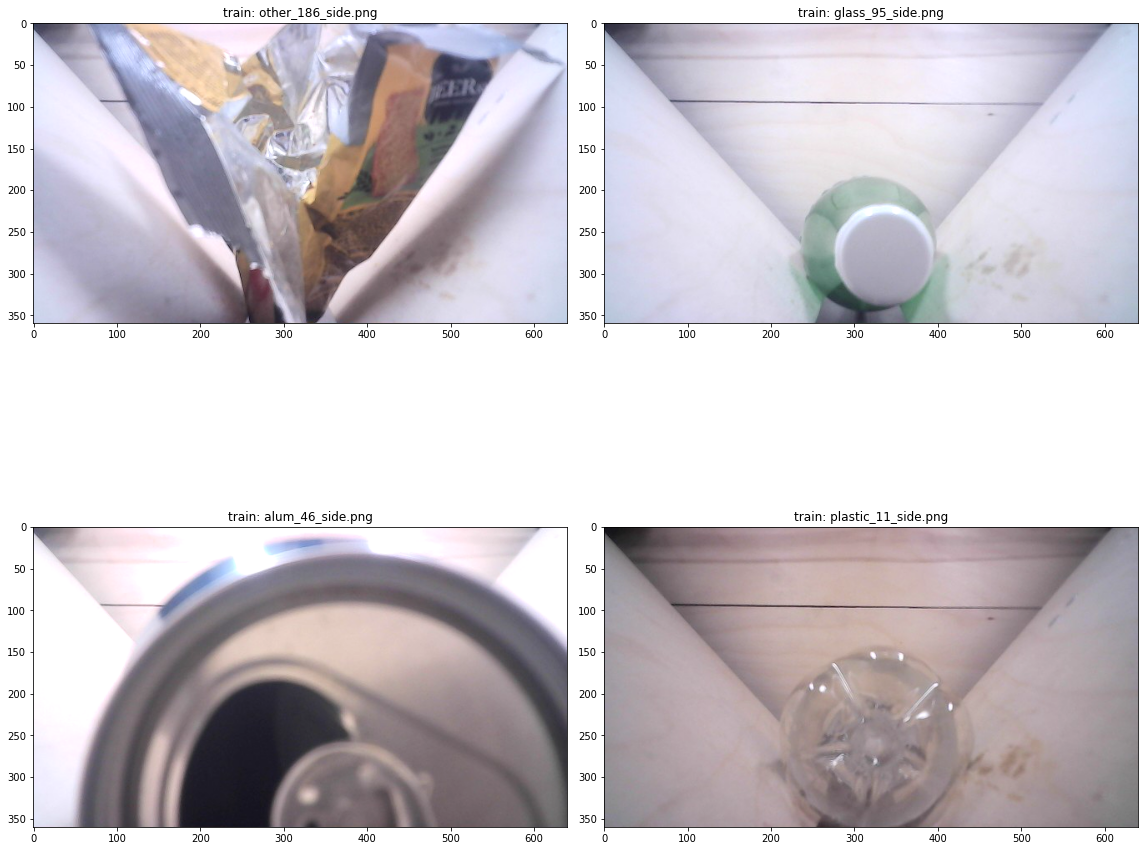

In [7]:
from vizualize import read_random_images, show_examples

images = read_random_images(train_images)
show_examples(images)


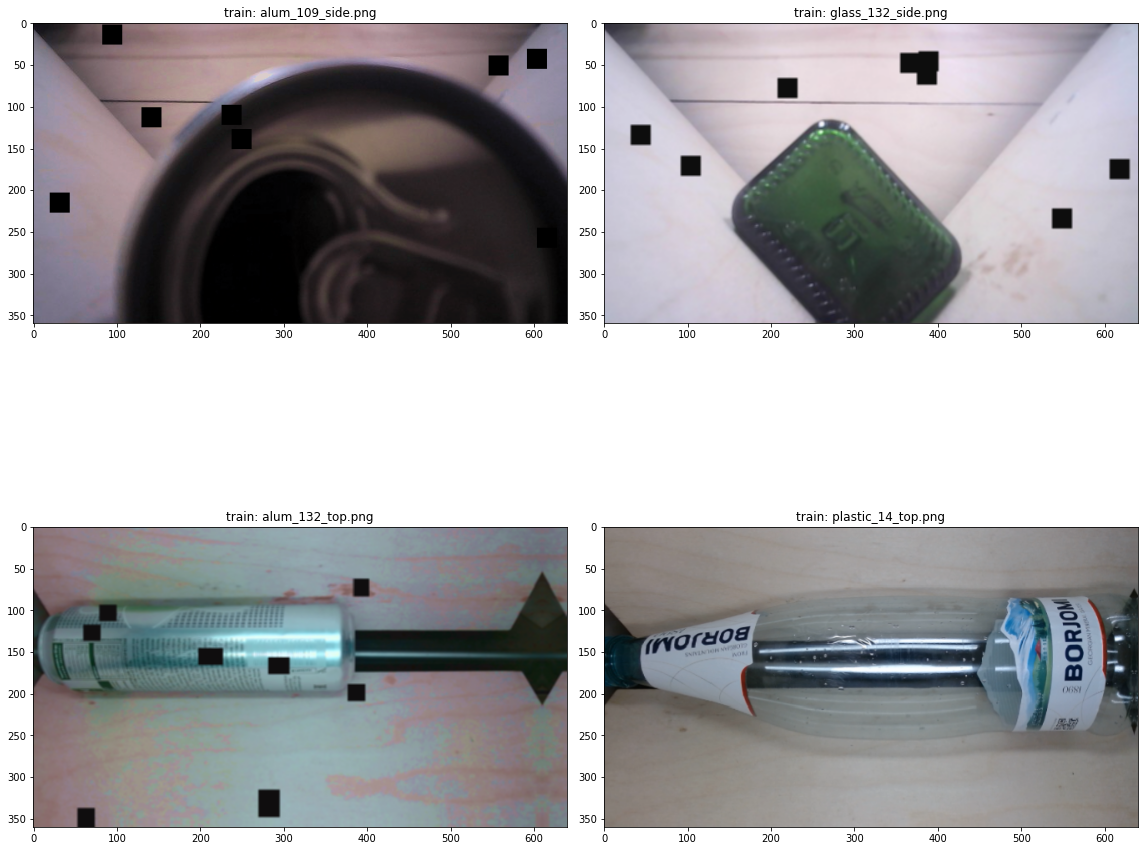

In [8]:
from preproccesing import get_show_transforms

show_transforms = get_show_transforms()

transformed_images = read_random_images(train_images, transform=show_transforms)
show_examples(transformed_images)


# 4 class

In [ ]:
from torch import nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from dataset import GarbageDataModule
import numpy as np
from pytorch_metric_learning import losses, miners, distances, reducers




model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model.features[0][0] = nn.Conv2d(
    6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)  # changing 3 input channels to 6``

num_classes = 4
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes) #output channels setting

model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 

model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
miner = miners.TripletMarginMiner(margin=0.4)

triplet_criterion= losses.TripletMarginLoss(margin=0.35, distance=distance, reducer=reducer)


labels_set = {
    "train_labels": ["alum", "plastic", "glass"],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    'train_labels_indom':["alum", "plastic", "glass"],
}


batch_size = 32

dm = GarbageDataModule(
    labels_set,
    data_dir=ROOT,
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()

epochs = 1000
softmax = nn.Softmax(dim=-1)

train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()

min_valid_loss = 999999
for e in range(epochs):
    train_loss = 0.0
    model.train()  
    train_acc =[]
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(train_dataloader):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels.to(device)
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        optimizer.zero_grad()

        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)

        output = model.classifier(features)

        # triplet_loss = triplet_criterion(features, labels, miner(output, labels))

        loss = 0.1 * criterion(output, labels) #+ triplet_loss
        # loss = triplet_loss

        acc = (output.argmax(dim=-1) == labels).float().mean()
        train_acc.append(acc.cpu().numpy())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()



    valid_loss = 0.0
    model.eval()  
    val_acc = []
    val_acc_others = []
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(val_dataloader):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels.to(device)
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        
        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)
     
        output = model.classifier(features)
        # triplet_loss = triplet_criterion(features, labels, miner(output, labels))

        loss = 0.1 * criterion(output, labels) #+  triplet_loss
        # loss = triplet_loss

        valid_loss += loss.item()

        probs = softmax(output)
        preds = probs.argmax(dim=-1)
        acc = (labels == preds).float().mean().cpu().numpy()
        acc_others = ((labels == 3) & (preds == 3)).float().mean().cpu().numpy()
        val_acc.append(acc)
        val_acc_others.append(acc_others)

    print(
        f"Epoch {e+1} \t Train Loss: {train_loss / len(train_dataloader) : 4f} \t Train acc: {np.mean(train_acc) : 3f}\t Val Loss: {valid_loss / len(val_dataloader): 4f} \t Val acc: {np.mean(val_acc): 3f} \t Val others acc: {np.mean(val_acc_others)}"
    )
    if min_valid_loss > valid_loss:
        print(
            f"Val Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model"
        )
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), "saved_model.pth")




Epoch 1 	 Train Loss:  1.393810 	 Train acc:  0.592548	 Val Loss:  0.503228 	 Val acc:  0.480469 	 Val others acc: 0.0
Val Loss Decreased(999999.000000--->4.025823) 	 Saving The Model
Epoch 2 	 Train Loss:  0.056433 	 Train acc:  0.927885	 Val Loss:  1.161966 	 Val acc:  0.480469 	 Val others acc: 0.0
Epoch 3 	 Train Loss:  0.007845 	 Train acc:  0.992788	 Val Loss:  0.772979 	 Val acc:  0.480469 	 Val others acc: 0.0
Epoch 4 	 Train Loss:  0.006451 	 Train acc:  0.993990	 Val Loss:  0.513073 	 Val acc:  0.570312 	 Val others acc: 0.0
Epoch 5 	 Train Loss:  0.006139 	 Train acc:  0.995192	 Val Loss:  0.421511 	 Val acc:  0.839844 	 Val others acc: 0.0
Val Loss Decreased(4.025823--->3.372088) 	 Saving The Model
Epoch 6 	 Train Loss:  0.006241 	 Train acc:  0.991587	 Val Loss:  0.405338 	 Val acc:  0.839844 	 Val others acc: 0.0
Val Loss Decreased(3.372088--->3.242701) 	 Saving The Model
Epoch 7 	 Train Loss:  0.006085 	 Train acc:  0.996394	 Val Loss:  0.397840 	 Val acc:  0.839844 	 Va

KeyboardInterrupt: 

In [ ]:
# test 4 class model

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model.features[0][0] = nn.Conv2d(
    6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)  # changing 3 input channels to 6``
model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 4) #output channels setting
model.load_state_dict(torch.load('saved_model.pth'))
model.to(device)


truth_labels = []
pred_labels = []
with torch.no_grad():
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(dm.test_dataloader()):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels.to(device)
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        
        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)


        logits = model.classifier(features)
        y_pred = torch.argmax(logits, axis=-1)
        truth_labels.extend(labels.cpu().numpy())
        pred_labels.extend(y_pred.cpu().numpy())


In [ ]:
(np.array(truth_labels) == np.array(pred_labels)).mean()

0.7637231503579952

# BAYES

In [ ]:
from torch import nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from bayesian_torch.utils.util import predictive_entropy, mutual_information
from dataset import GarbageDataModule
import numpy as np

torch.cuda.empty_cache()

const_bnn_prior_parameters = {
    "prior_mu": 0.0,
    "prior_sigma": 1.0,
    "posterior_mu_init": 0.0,
    "posterior_rho_init": -3.0,
    "type": "Reparameterization",  # Flipout or Reparameterization 
    "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
    "moped_delta": 0.5,
}


model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model.features[0][0] = nn.Conv2d(
    6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)  # changing 3 input channels to 6``
model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 3) #output channels setting
model.load_state_dict(torch.load('saved_model.pth'))


# num_classes = 3
# model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes) #output channels setting

# model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 

dnn_to_bnn(model.classifier, const_bnn_prior_parameters)

model.to(device)
optimizer = optim.AdamW([
    {"params": model.features.parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 1e-3},
    ])
criterion = nn.CrossEntropyLoss()

num_mc = 20


labels_set = {
    "train_labels": ["alum", "plastic", "glass"],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    'train_labels_indom':["alum", "plastic", "glass"],
}

batch_size = 32

dm = GarbageDataModule(
    labels_set,
    data_dir=ROOT,
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()

epochs = 1000
softmax = nn.Softmax(dim=-1)

# train_dataloader = dm.train_dataloader_indom()
# val_dataloader = dm.val_dataloader_indom()
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()

min_valid_loss = 999999
for e in range(epochs):
    train_loss = 0.0
    model.train()  # Optional when not using Model Specific layer
    train_acc =[]
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(train_dataloader):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels.to(device)
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        optimizer.zero_grad()

        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)

        kl_ = []
        outputs_ = []
        for _ in range(num_mc):
            logits = model.classifier(features)
            outputs_.append(logits)
            kl = get_kl_loss(model)
            kl_.append(kl)

        output = torch.mean(torch.stack(outputs_), dim=0)
        kl = torch.mean(torch.stack(kl_), dim=0)

        loss = criterion(output, labels) + (kl / batch_size).to(device)
        acc = (output.argmax(dim=-1) == labels).float().mean()
        train_acc.append(acc.cpu().numpy())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()



    valid_loss = 0.0
    model.eval()  # Optional when not using Model Specific layer
    val_acc = []
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(val_dataloader):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels.to(device)
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        
        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)
        kl_ = []
        outputs_ = []
        for _ in range(num_mc):
            logits = model.classifier(features)
            outputs_.append(logits)
            kl = get_kl_loss(model)
            kl_.append(kl)

        output = torch.mean(torch.stack(outputs_), dim=0)
        kl = torch.mean(torch.stack(kl_), dim=0)
        loss = criterion(output, labels) +  (kl / batch_size).to(device)
        valid_loss += loss.item()

        probs = softmax(output)
        preds = probs.argmax(dim=-1)
        acc = (labels == preds).float().mean()
        val_acc.append(acc.cpu().numpy())


    print(
        f"Epoch {e+1} \t Train Loss: {train_loss / len(train_dataloader) : 4f} \t Train acc: {np.mean(train_acc) : 3f}\t Val Loss: {valid_loss / len(val_dataloader): 4f} \t Val acc: {np.mean(val_acc): 3f}"
    )
    if min_valid_loss > valid_loss:
        print(
            f"Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model"
        )
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), "bayes_saved_model.pth")




Epoch 1 	 Train Loss:  0.604362 	 Train acc:  0.975962	 Val Loss:  3.857954 	 Val acc:  0.808594
Validation Loss Decreased(999999.000000--->30.863634) 	 Saving The Model
Epoch 2 	 Train Loss:  2.248918 	 Train acc:  0.844952	 Val Loss:  3.099354 	 Val acc:  0.839844
Validation Loss Decreased(30.863634--->24.794833) 	 Saving The Model
Epoch 3 	 Train Loss:  0.559047 	 Train acc:  0.996394	 Val Loss:  4.434811 	 Val acc:  0.839844
Epoch 4 	 Train Loss:  0.524539 	 Train acc:  0.998798	 Val Loss:  4.519821 	 Val acc:  0.839844
Epoch 5 	 Train Loss:  0.522182 	 Train acc:  0.998798	 Val Loss:  4.357220 	 Val acc:  0.839844
Epoch 6 	 Train Loss:  0.517500 	 Train acc:  1.000000	 Val Loss:  4.529209 	 Val acc:  0.839844
Epoch 7 	 Train Loss:  0.527909 	 Train acc:  0.998798	 Val Loss:  4.440881 	 Val acc:  0.839844
Epoch 8 	 Train Loss:  0.513702 	 Train acc:  1.000000	 Val Loss:  4.416750 	 Val acc:  0.839844
Epoch 9 	 Train Loss:  0.511394 	 Train acc:  1.000000	 Val Loss:  4.636154 	 Val 

KeyboardInterrupt: 

## Testing

In [ ]:
model.load_state_dict(torch.load('bayes_saved_model.pth'))


<All keys matched successfully>

In [ ]:
from bayesian_torch.utils.util import predictive_entropy, mutual_information
model.eval()
truth_labels = []
pred_labels = []

predictive_uncertainties = []
model_uncertaintis = []


with torch.no_grad():
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(dm.test_dataloader()):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels.to(device)
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        
        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)

        output_mc = []

        for mc_run in range(20):
            logits = model.classifier(features)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            output_mc.append(probs)
        output = torch.stack(output_mc)  
        pred_mean = output.mean(dim=0)
        y_pred = torch.argmax(pred_mean, axis=-1)
        truth_labels.extend(labels.cpu().numpy())
        pred_labels.extend(y_pred.cpu().numpy())

        predictive_uncertainty = predictive_entropy(output.data.cpu().numpy())
        model_uncertainty = mutual_information(output.data.cpu().numpy())

        predictive_uncertainties.extend(predictive_uncertainty)
        model_uncertaintis.extend(model_uncertainty)


    
    

In [ ]:
len(model_uncertaintis)

419

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'truth': truth_labels, 
    'pred_class' : pred_labels, 
    'pred_unc' : predictive_uncertainties, 
    'mod_unc' : model_uncertaintis})
df


,truth,pred_class,pred_unc,mod_unc
0,1,1,0.000065,8.367351e-07
1,1,1,0.000086,6.356495e-07
2,1,1,0.000113,7.934432e-07
3,1,1,0.000111,1.039531e-06
4,1,1,0.000060,4.569156e-07
...,...,...,...,...
414,0,0,0.142444,4.791337e-02
415,0,0,0.356981,1.622375e-01
416,0,0,0.156243,4.528910e-02
417,0,0,0.082533,2.007915e-02


In [ ]:
df['truth'].value_counts()

0    125
1    123
2     90
3     81
Name: truth, dtype: int64

In [ ]:
(df[df['truth'] != 3]['truth'] == df[df['truth'] != 3]['pred_class']).mean()

0.9319526627218935

<AxesSubplot:>

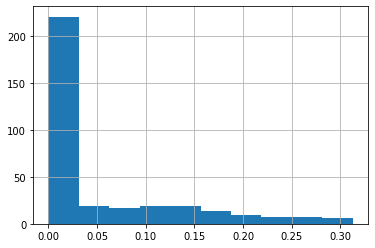

In [ ]:
df[df['truth'] != 3]['mod_unc'].hist()

<AxesSubplot:>

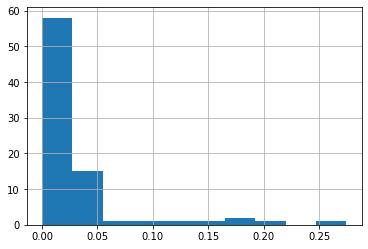

In [ ]:
df[df['truth'] == 3]['mod_unc'].hist()

<AxesSubplot:>

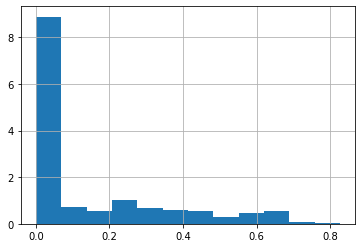

In [ ]:
df[df['truth'] != 3]['pred_unc'].hist(bins=12, density=True)


<AxesSubplot:>

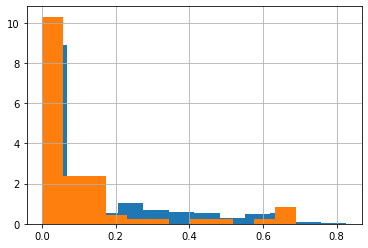

In [ ]:
df[df['truth'] != 3]['pred_unc'].hist(bins=12, density=True)
df[df['truth'] == 3]['pred_unc'].hist(bins=12, density=True)

<AxesSubplot:>

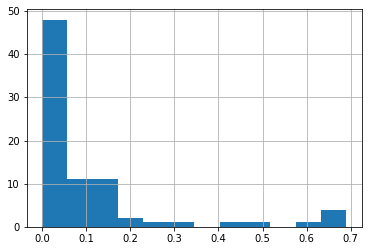

In [ ]:
df[df['truth'] == 3]['pred_unc'].hist(bins=12)

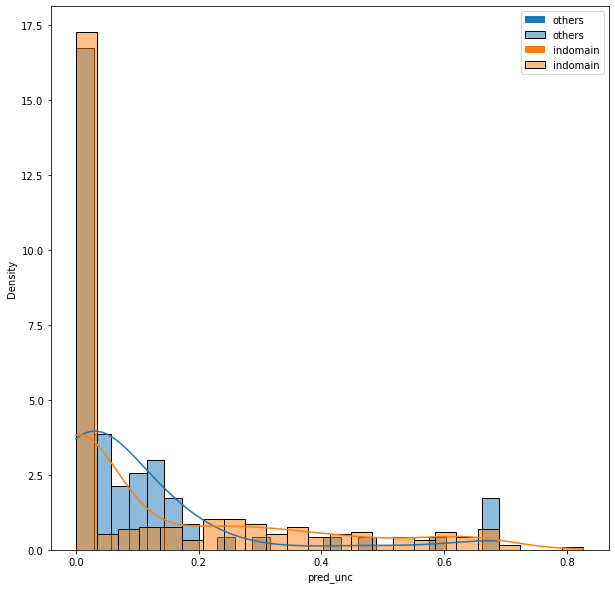

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 10)) 
sns.histplot(df[df['truth'] == 3]['pred_unc'], kde=True, bins = 24, stat='density', label='others')
sns.histplot(df[df['truth'] != 3]['pred_unc'], kde=True, bins = 24, stat='density', label = 'indomain')
plt.legend()
# sns.displot(df[df['truth'] != 3]['pred_unc'], kde=True)


In [ ]:
threshold = 0.1

# (df[df['truth'] == 3]['pred_unc'] > threshold).sum()


((df['pred_unc'] > threshold) & (df['truth'] == 3) &  (df['pred_class'] != 3) ).sum()
# ((df['pred_unc'] > threshold) & (df['truth'] != 3) ).sum()



48

In [ ]:
(df['truth'] == df['pred_class']).mean()

0.7374701670644391

In [ ]:
# df['uncertainty'] = df['pred_unc'] > 0.15
# df['new_pred'] = df['pred_class'] 
df['new_pred'] = df.apply(lambda row: row['pred_class'] if row['pred_unc'] < 0.1 else 3, axis=1)
(df['truth'] == df['new_pred'] ).mean()

0.5966587112171837

In [ ]:
df.shape

(419, 6)

# Out of Distribution Detection via Neural Network Anchoring

https://arxiv.org/pdf/2207.04125.pdf

## 2 imgs

In [25]:
from torch import nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from dataset import GarbageDataModule
import numpy as np
from pytorch_metric_learning import losses, miners, distances, reducers



model = mobilenet_v3_small()
model.features[0][0] = nn.Conv2d(
    12, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)  # changing 3 input channels to 12

num_classes = 3
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes) #output channels setting

# model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 

model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.01,
#                       momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

labels_set = {
    "train_labels": ["alum", "plastic", "glass"],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    'train_labels_indom':["alum", "plastic", "glass"],
}


batch_size = 64

dm = GarbageDataModule(
    labels_set,
    data_dir=ROOT,
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()

epochs = 1000
softmax = nn.Softmax(dim=-1)

train_dataloader = dm.train_dataloader_no_augs_indom()
val_dataloader = dm.val_dataloader_indom()

train_losses = []
train_accs = []

min_valid_loss = 999999
for e in range(epochs):
    train_loss = 0.0
    model.train()  
    train_acc =[]
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(train_dataloader):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels.to(device)
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        concat_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)

        anchors = concat_imgs[torch.randperm(len(concat_imgs))]
        input_imgs = torch.cat((anchors, concat_imgs-anchors), axis=1)
        
        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
     
        output = model.classifier(features)
        loss = criterion(output, labels)

        acc = (output.argmax(dim=-1) == labels).float().mean()
        train_acc.append(acc.cpu().numpy())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()



    # valid_loss = 0.0
    # model.eval()  
    # val_acc = []
    # val_acc_others = []
    # for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(val_dataloader):
    #     top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
    #     labels = labels.to(device)
    #     metal = metal.to(device).view(-1, 1).float()
    #     weights = weights.to(device).view(-1, 1).float()
    #     concat_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)

    #     anchors = concat_imgs[torch.randperm(len(concat_imgs))]
    #     input_imgs = torch.cat((anchors, concat_imgs-anchors), axis=1)
        
    #     features = model.features(input_imgs)
    #     features = model.avgpool(features)
    #     features = torch.flatten(features, 1)
     
    #     output = model.classifier(features)
    #     loss = criterion(output, labels)

    #     valid_loss += loss.item()

    #     probs = softmax(output)
    #     preds = probs.argmax(dim=-1)
    #     acc = (labels == preds).float().mean().cpu().numpy()
    #     acc_others = ((labels == 3) & (preds == 3)).float().mean().cpu().numpy()
    #     val_acc.append(acc)
    #     val_acc_others.append(acc_others)

    train_accs.append(np.mean(train_acc) )
    train_losses.append(train_loss / len(train_dataloader))
    print(
        f"Epoch {e+1} \t Train Loss: {train_loss / len(train_dataloader) : 4f} \t Train acc: {np.mean(train_acc) : 3f}"
    )

    # print(
    #     f"Epoch {e+1} \t Train Loss: {train_loss / len(train_dataloader) : 4f} \t Train acc: {np.mean(train_acc) : 3f}\t Val Loss: {valid_loss / len(val_dataloader): 4f} \t Val acc: {np.mean(val_acc): 3f} "
    # )
    # if min_valid_loss > valid_loss:
    #     print(
    #         f"Val Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model"
    #     )
    #     min_valid_loss = valid_loss
    #     # Saving State Dict
    #     torch.save(model.state_dict(), "saved_model.pth")




Epoch 1 	 Train Loss:  20.627346 	 Train acc:  0.424851
Epoch 2 	 Train Loss:  57.773650 	 Train acc:  0.302827
Epoch 3 	 Train Loss:  77.228730 	 Train acc:  0.250744
Epoch 4 	 Train Loss:  399.134701 	 Train acc:  0.036830
Epoch 5 	 Train Loss:  99.809545 	 Train acc:  0.475446
Epoch 6 	 Train Loss:  99.988389 	 Train acc:  0.226562
Epoch 7 	 Train Loss:  57.866625 	 Train acc:  0.088170
Epoch 8 	 Train Loss:  174.492507 	 Train acc:  0.266741
Epoch 9 	 Train Loss:  339.191369 	 Train acc:  0.455357
Epoch 10 	 Train Loss:  393.008519 	 Train acc:  0.360491
Epoch 11 	 Train Loss:  1007.085332 	 Train acc:  0.359375
Epoch 12 	 Train Loss:  275.335473 	 Train acc:  0.388393
Epoch 13 	 Train Loss:  116.462674 	 Train acc:  0.540179
Epoch 14 	 Train Loss:  295.555920 	 Train acc:  0.479911
Epoch 15 	 Train Loss:  3234.056121 	 Train acc:  0.227679
Epoch 16 	 Train Loss:  218.713024 	 Train acc:  0.393973
Epoch 17 	 Train Loss:  5.462856 	 Train acc:  0.511161
Epoch 18 	 Train Loss:  9.480

KeyboardInterrupt: 

Text(0.5, 0, 'Epochs')

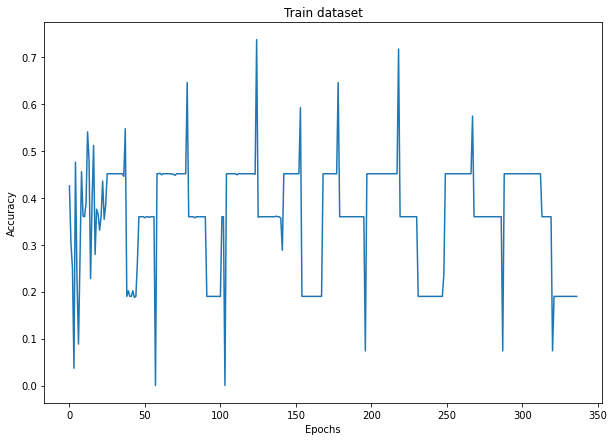

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(train_accs)
plt.ylabel('Accuracy')
plt.title('Train dataset')
plt.xlabel('Epochs')


Text(0.5, 0, 'Epochs')

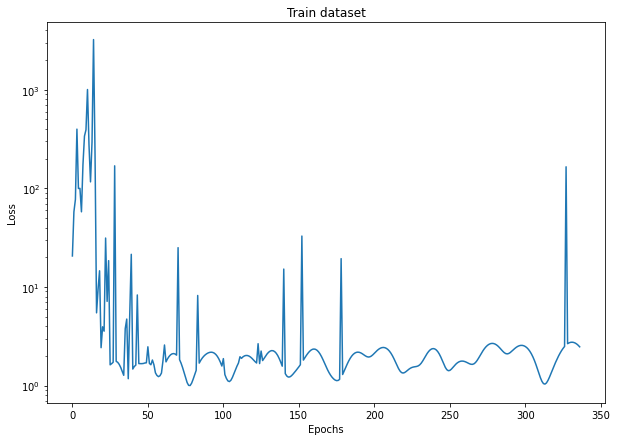

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.yscale('log')
plt.plot(train_losses)
plt.ylabel('Loss')
plt.title('Train dataset')
plt.xlabel('Epochs')



# Pytorch-OOD

## CAC Loss (3 classes)

In [9]:
from torch import nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from dataset import GarbageDataModule
import numpy as np
from pytorch_ood.loss import CACLoss
from pytorch_ood.utils import OODMetrics
from sklearn.manifold import TSNE




model = mobilenet_v3_small()
model.features[0][0] = nn.Conv2d(
    6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)  # changing 3 input channels to 6``

num_classes = 3
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes) #output channels setting

model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 
# model.load_state_dict(torch.load('saved_cac/cac_sensors_unnormalized.pth'))


model.to(device)
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-2},
    {'params': model.classifier.parameters(), 'lr': 1e-2}
    ])


criterion = CACLoss(n_classes=num_classes, magnitude=5, alpha=2).to(device)


labels_set = {
    "train_labels": ["alum", "plastic", "glass", 'other'],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    'train_labels_indom':["alum", "plastic", "glass"],
}


batch_size = 64

dm = GarbageDataModule(
    labels_set,
    data_dir=ROOT,
    batch_size=batch_size,
    num_workers=16,
)
dm.setup()

epochs = 1000
softmax = nn.Softmax(dim=-1)

train_dataloader = dm.train_dataloader_indom()
val_dataloader = dm.val_dataloader_binary()
metrics = OODMetrics()
best_auroc = 0


min_valid_loss = 1e10

for e in range(epochs):
    train_loss = 0.0
    model.train()  
    train_acc =[]
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(train_dataloader):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels.to(device)
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        optimizer.zero_grad()

        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)

        output = model.classifier(features)
        distances = criterion.calculate_distances(output)

        loss = criterion(distances, labels) 

        acc = (output.argmax(dim=-1) == labels).float().mean()
        train_acc.append(acc.cpu().numpy())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()



    valid_loss = 0.0
    model.eval()  
    val_acc = []
    val_acc_others = []

    with torch.no_grad():
        for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(val_dataloader):
            top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
            labels = labels.to(device)
            metal = metal.to(device).view(-1, 1).float()
            weights = weights.to(device).view(-1, 1).float()
            input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
            
            features = model.features(input_imgs)
            features = model.avgpool(features)
            features = torch.flatten(features, 1)
            features = torch.cat((features, metal, weights), 1)
        
            output = model.classifier(features)
            distances = criterion.calculate_distances(output).cpu()

            score = CACLoss.score(distances)
            # print(score.shape, labels.shape)
            metrics.update(score, labels)
            
            # distances = val_criterion.calculate_distances(output)
            # loss = val_criterion(distances, labels) 
            # valid_loss += loss.item()

            probs = softmax(output)
            preds = probs.argmax(dim=-1)
            acc = (labels == preds).float().mean().cpu().numpy()
            acc_others = ((labels == 3) & (preds == 3)).float().mean().cpu().numpy()
            # val_acc.append(acc)
            # val_acc_others.append(acc_others)

    metrics_res = metrics.compute()

    print(
        f"Epoch {e+1} \t Train Loss: {train_loss / len(train_dataloader) : 4f} \t Train acc: {np.mean(train_acc) : 3f}\t Val Loss: {valid_loss / len(val_dataloader): 4f} \t Val acc: {np.mean(val_acc): 3f} \t AUROC: {metrics_res['AUROC'] }"
    )

    # print(metrics.compute())
    if best_auroc < metrics_res['AUROC'] :
        print(f"AUROC increased({best_auroc:.6f}--->{metrics_res['AUROC'] :.6f}) \t Saving The Model")
        best_auroc = metrics_res['AUROC']
        # Saving State Dict
        torch.save(criterion.state_dict(), 'cac_loss_auroc_no_sensors_criterion.pth')
        torch.save(model.state_dict(), "cac_loss_auroc_no_sensors_model.pth")




/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/michael/miniconda3/envs/greenbox/lib/python3.9/site-packages/pytorch_ood/loss/cac.py:79: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:671.)
  non_target[is_last_class, target_known[is_last_class]] = self.

Epoch 1 	 Train Loss:  6149.918971 	 Train acc:  0.472098	 Val Loss:  0.000000 	 Val acc:  0.847656 	 AUROC: 0.5150970816612244
AUROC increased(0.000000--->0.515097) 	 Saving The Model
Epoch 2 	 Train Loss:  15509.279526 	 Train acc:  0.381696	 Val Loss:  0.000000 	 Val acc:  0.000000 	 AUROC: 0.519889771938324
AUROC increased(0.515097--->0.519890) 	 Saving The Model
Epoch 3 	 Train Loss:  2673.035749 	 Train acc:  0.315848	 Val Loss:  0.000000 	 Val acc:  0.000000 	 AUROC: 0.5018904805183411
Epoch 4 	 Train Loss:  1738.867239 	 Train acc:  0.356771	 Val Loss:  0.000000 	 Val acc:  0.000000 	 AUROC: 0.5080801844596863
Epoch 5 	 Train Loss:  994.145214 	 Train acc:  0.308408	 Val Loss:  0.000000 	 Val acc:  0.003906 	 AUROC: 0.5199760794639587
AUROC increased(0.519890--->0.519976) 	 Saving The Model
Epoch 6 	 Train Loss:  817.463486 	 Train acc:  0.257068	 Val Loss:  0.000000 	 Val acc:  0.496094 	 AUROC: 0.522076427936554
AUROC increased(0.519976--->0.522076) 	 Saving The Model
Epoch 7

In [65]:
# torch.save(criterion.state_dict(), '6_cac_loss_saved_criterion.pth')
# torch.save(model.state_dict(), "6_cac_loss_saved_model.pth")

## Testing

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

labels_set = {
    "train_labels": ["alum", "plastic", "glass", 'other'],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    'train_labels_indom':["alum", "plastic", "glass"],
}


batch_size = 48
dm = GarbageDataModule(
    labels_set,
    data_dir=ROOT,
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()

def test_tsne_of_model(model, dataloader=dm.test_dataloader(), sensors=True):
    model.eval()
    outputs = []
    
    truth = []
    with torch.no_grad():
        for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(dataloader):
            top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
            labels = labels
            metal = metal.to(device).view(-1, 1).float()
            weights = weights.to(device).view(-1, 1).float()
            input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
            
            features = model.features(input_imgs)
            features = model.avgpool(features)
            features = torch.flatten(features, 1)
            if sensors:
                features = torch.cat((features, metal, weights), 1)

            outputs.extend(features.cpu())
            truth.extend(labels.cpu())

    tsne = TSNE(n_components=2, random_state=123)
    tsne_result = tsne.fit_transform(torch.stack(outputs) ) 
    print(tsne_result.shape)
    plt.figure(figsize=(10, 10))

    classes = [3, 0, 1, 2]

    for c in classes:
        points = []
        for i, j in zip(tsne_result, truth):
            if j == c:
                points.append(i)
        
        if len(points) == 0:
            print('no class', c)
            continue
        points = np.array(points)
        plt.scatter(x=points[:, 0], y=points[:, 1], label = c)

    plt.legend()



model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
model.features[0][0] = nn.Conv2d(
    6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)  # changing 3 input channels to 6

num_classes = 3
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes) #output channels setting

model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 
model.to(device)
# model.load_state_dict(torch.load('cac_loss_norm_sensors_saved_model.pth'))
dm = GarbageDataModule(
    labels_set,
    data_dir=ROOT,
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()

model.load_state_dict(torch.load('classifier_sensors.pth'))


test_tsne_of_model(model, dm.train_dataloader())

RuntimeError: Error(s) in loading state_dict for MobileNetV3:
	size mismatch for classifier.3.weight: copying a param with shape torch.Size([4, 1024]) from checkpoint, the shape in current model is torch.Size([3, 1024]).
	size mismatch for classifier.3.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([3]).

In [28]:

model = mobilenet_v3_small()
model.features[0][0] = nn.Conv2d(
    6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)  # changing 3 input channels to 6

num_classes = 3
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes) #output channels setting

model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 
model.to(device)

labels_set = {
    "train_labels": ["alum", "plastic", "glass", 'other'],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    'train_labels_indom':["alum", "plastic", "glass"],
}
batch_size=32
dm = GarbageDataModule(
    labels_set,
    data_dir=ROOT,
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()

model.load_state_dict(torch.load('saved_cac/cac_sensors_unnormalized.pth'))

model.eval()
outputs = []

truth = []

softmax = nn.Softmax()
with torch.no_grad():
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(dm.test_dataloader()):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        
        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)
        logits = model.classifier(features)
        probs = softmax(logits.cpu())

        outputs.extend(probs)
        truth.extend(labels)

/tmp/ipykernel_3276734/505465848.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = softmax(logits.cpu())


In [17]:
import pandas as pd
# outputs = torch.stack(outputs)
# truth = torch.stack(truth)
df = pd.DataFrame({'truth': truth.numpy(), 'plastic_prob' : outputs[:, 0], 'alum_prob' : outputs[:, 1], 'glass_prob' : outputs[:, 2], })
df

,truth,plastic_prob,alum_prob,glass_prob
0,1,0.005767,0.988609,0.005624
1,1,0.005885,0.987248,0.006867
2,1,0.006104,0.986806,0.007089
3,1,0.006210,0.987840,0.005950
4,1,0.006146,0.986537,0.007317
...,...,...,...,...
414,0,0.973786,0.011113,0.015101
415,0,0.963160,0.019694,0.017146
416,0,0.975249,0.011761,0.012989
417,0,0.972680,0.013280,0.014039


<AxesSubplot:xlabel='plastic_prob', ylabel='Count'>

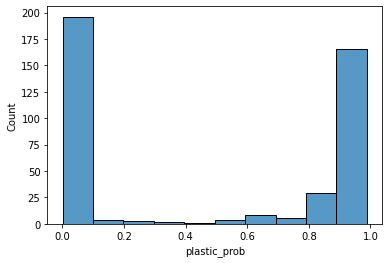

In [22]:
import seaborn as sns
sns.histplot(df)

array([[<AxesSubplot:title={'center':'truth'}>,
        <AxesSubplot:title={'center':'plastic_prob'}>],
       [<AxesSubplot:title={'center':'alum_prob'}>,
        <AxesSubplot:title={'center':'glass_prob'}>]], dtype=object)

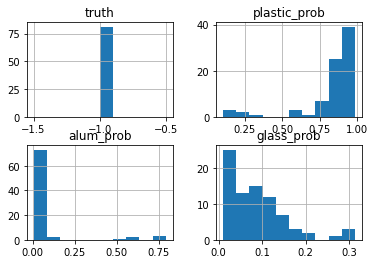

In [26]:
df[df['truth'] == -1].hist()

## Train classifier

In [14]:
from torch import nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from dataset import GarbageDataModule
import numpy as np
from pytorch_ood.loss import CACLoss
from pytorch_ood.utils import OODMetrics




model = mobilenet_v3_small()
model.features[0][0] = nn.Conv2d(
    6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)  # changing 3 input channels to 6

model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 3) 
model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 
model.load_state_dict(torch.load('cac_loss_auroc_no_sensors_model.pth'))


num_classes = 4
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes) #output channels setting

model.to(device)

labels_set = {
    "train_labels": ["alum", "plastic", "glass", 'other'],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    'train_labels_indom':["alum", "plastic", "glass"],
}
batch_size=32
dm = GarbageDataModule(
    labels_set,
    data_dir=ROOT,
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()


optimizer = optim.AdamW([
    {"params": model.features.parameters(), "lr": 0},
    {"params": model.classifier.parameters(), "lr": 1e-2},
] )

criterion = nn.CrossEntropyLoss()
cac_criterion = CACLoss(n_classes=num_classes, magnitude=9, alpha=2).to(device)
cac_loss_weight = 0.01

epochs = 1000
softmax = nn.Softmax(dim=-1)

train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()

min_valid_loss = 1e10
for e in range(epochs):
    train_loss = 0.0
    model.train()  
    train_acc =[]
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(train_dataloader):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels.to(device)
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        optimizer.zero_grad()

        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)
        output = model.classifier(features)

        # distances = cac_criterion.calculate_distances(output)
        # cac_loss = cac_criterion(distances, labels) 
        loss = criterion(output, labels) #+ cac_loss_weight * cac_loss

        acc = (output.argmax(dim=-1) == labels).float().mean()
        train_acc.append(acc.cpu().numpy())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()



    valid_loss = 0.0
    model.eval()  
    val_acc = []
    val_acc_others = []
    with torch.no_grad():
        for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(val_dataloader):
            top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
            labels = labels.to(device)
            metal = metal.to(device).view(-1, 1).float()
            weights = weights.to(device).view(-1, 1).float()
            input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
            
            features = model.features(input_imgs)
            features = model.avgpool(features)
            features = torch.flatten(features, 1)
            features = torch.cat((features, metal, weights), 1)
        
            output = model.classifier(features)
            
            # distances = cac_criterion.calculate_distances(output)
            # cac_loss = cac_criterion(distances, labels) 
            loss = criterion(output, labels) #+ cac_loss_weight * cac_loss
            valid_loss += loss.item()

            probs = softmax(output)
            preds = probs.argmax(dim=-1)
            acc = (labels == preds).float().mean().cpu().numpy()
            acc_others = ((labels == 3) & (preds == 3)).float().mean().cpu().numpy()
            val_acc.append(acc)
            val_acc_others.append(acc_others)

    print(
        f"Epoch {e+1} \t Train Loss: {train_loss / len(train_dataloader) : 4f} \t Train acc: {np.mean(train_acc) : 3f}\t Val Loss: {valid_loss / len(val_dataloader): 4f} \t Val acc: {np.mean(val_acc): 3f} \t Val others acc: {np.mean(val_acc_others)}"
    )

    # print(metrics.compute())
    if min_valid_loss > valid_loss:
        print(
            f"Val Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model"
        )
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), "6_classifier_sensors.pth")




Epoch 1 	 Train Loss:  2.715818 	 Train acc:  0.660282	 Val Loss:  29.811701 	 Val acc:  0.292969 	 Val others acc: 0.0
Val Loss Decreased(10000000000.000000--->238.493605) 	 Saving The Model
Epoch 2 	 Train Loss:  12.458736 	 Train acc:  0.339718	 Val Loss:  15.959331 	 Val acc:  0.292969 	 Val others acc: 0.0
Val Loss Decreased(238.493605--->127.674651) 	 Saving The Model
Epoch 3 	 Train Loss:  8.223977 	 Train acc:  0.286290	 Val Loss:  7.733591 	 Val acc:  0.308594 	 Val others acc: 0.015625
Val Loss Decreased(127.674651--->61.868725) 	 Saving The Model
Epoch 4 	 Train Loss:  6.149664 	 Train acc:  0.340726	 Val Loss:  5.183050 	 Val acc:  0.320312 	 Val others acc: 0.0078125
Val Loss Decreased(61.868725--->41.464398) 	 Saving The Model
Epoch 5 	 Train Loss:  5.160829 	 Train acc:  0.315524	 Val Loss:  3.036568 	 Val acc:  0.351562 	 Val others acc: 0.0078125
Val Loss Decreased(41.464398--->24.292541) 	 Saving The Model
Epoch 6 	 Train Loss:  3.686901 	 Train acc:  0.419355	 Val Lo

Exception ignored in: <function _releaseLock at 0x7f0368ae89d0>
Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/greenbox/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Epoch 139 	 Train Loss:  0.540013 	 Train acc:  0.816532	 Val Loss:  2.702733 	 Val acc:  0.882004 	 Val others acc: 0.0703125


KeyboardInterrupt: 

## Testing

In [9]:

model = mobilenet_v3_small()
model.features[0][0] = nn.Conv2d(
    6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)  # changing 3 input channels to 6

model.classifier[0] = nn.Linear(model.classifier[0].in_features + 2, model.classifier[0].out_features) 
num_classes = 4
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes) #output channels setting

model.load_state_dict(torch.load('classifier_sensors.pth'))
model.to(device)
model.eval()


batch_size=32

labels_set = {
    "train_labels": ["alum", "plastic", "glass", 'other'],
    "val_labels": ["alum", "plastic", "glass", "other"],
    "val_labels_indom": ["alum", "plastic", "glass"],
    "test_labels": ["alum", "plastic", "glass", "other"],
    'train_labels_indom':["alum", "plastic", "glass"],
}
dm = GarbageDataModule(
    labels_set,
    data_dir=ROOT,
    batch_size=batch_size,
    num_workers=10,
)
dm.setup()

outputs = []

truth = []

softmax = nn.Softmax(dim=1)
sigmoid = nn.Sigmoid()

with torch.no_grad():
    for i_step, (top_imgs, side_imgs, metal, weights, labels, _) in enumerate(dm.test_dataloader()):
        top_imgs, side_imgs = top_imgs['image'], side_imgs['image']
        labels = labels
        metal = metal.to(device).view(-1, 1).float()
        weights = weights.to(device).view(-1, 1).float()
        input_imgs = torch.cat((top_imgs, side_imgs), 1).to(device)
        # print(input_imgs.shape)
        
        features = model.features(input_imgs)
        features = model.avgpool(features)
        features = torch.flatten(features, 1)
        features = torch.cat((features, metal, weights), 1)
        logits = model.classifier(features)
        probs = softmax(logits.cpu())
        # probs = sigmoid(logits.cpu())


        outputs.extend(probs)
        truth.extend(labels)
outputs = torch.stack(outputs)
truth = torch.stack(truth)

In [10]:
# Total accuracy
(outputs.argmax(-1) == truth).sum()/len(truth)

tensor(0.9214)

In [11]:
# In domain acc
((outputs.argmax(-1) == truth) & (truth != 3)).sum()/(truth != 3).sum()

tensor(0.9540)

In [12]:
# OOD domain acc
((outputs.argmax(-1) == truth) & (truth == 3)).sum()/(truth == 3).sum()

tensor(0.7901)

In [13]:
import pandas as pd
df = pd.DataFrame({'truth': truth.numpy(), 'plastic_prob' : outputs[:, 0], 'alum_prob' : outputs[:, 1], 'glass_prob' : outputs[:, 2], 'other_prob' : outputs[:, 3],  })
df

,truth,plastic_prob,alum_prob,glass_prob,other_prob
0,1,0.000006,0.999485,0.000006,0.000502
1,1,0.000028,0.999520,0.000020,0.000431
2,1,0.000028,0.999617,0.000024,0.000332
3,1,0.000008,0.999448,0.000007,0.000538
4,1,0.000029,0.999471,0.000024,0.000476
...,...,...,...,...,...
402,0,0.992908,0.000102,0.000778,0.006212
403,0,0.984829,0.000013,0.002005,0.013152
404,0,0.991664,0.000040,0.001162,0.007134
405,0,0.990116,0.000050,0.001286,0.008548


In [14]:
# STOCK 
df['pred']= df[['plastic_prob',	'alum_prob','glass_prob','other_prob']].idxmax(1)
df['pred'] = df['pred'].replace({'plastic_prob': 0,	'alum_prob':1,'glass_prob':2,'other_prob':3})
# Total acc, ood acc, indom acc
(df['pred'] == df['truth']).mean(), ((df['pred'] == df['truth']) & (df['truth'] == 3) ).sum()/(truth==3).sum(),  ((df['pred'] == df['truth'] ) & (df['truth'] != 3) ).sum()/(truth!=3).sum(), 

(0.9213759213759214, tensor(0.7901), tensor(0.9540))

In [15]:
# Multiplier x20
df['other_prob'] *= 20
df['pred']= df[['plastic_prob',	'alum_prob','glass_prob','other_prob']].idxmax(1)
df['pred'] = df['pred'].replace({'plastic_prob': 0,	'alum_prob':1,'glass_prob':2,'other_prob':3})
# Total acc, ood acc, indom acc
(df['pred'] == df['truth']).mean(), ((df['pred'] == df['truth']) & (df['truth'] == 3) ).sum()/(truth==3).sum(),  ((df['pred'] == df['truth'] ) & (df['truth'] != 3) ).sum()/(truth!=3).sum(), 

(0.9336609336609336, tensor(0.8889), tensor(0.9448))

In [16]:
# Multiplier x30
df['other_prob'] *= 1.5
df['pred']= df[['plastic_prob',	'alum_prob','glass_prob','other_prob']].idxmax(1)
df['pred'] = df['pred'].replace({'plastic_prob': 0,	'alum_prob':1,'glass_prob':2,'other_prob':3})
# Total acc, ood acc, indom acc
(df['pred'] == df['truth']).mean(), ((df['pred'] == df['truth']) & (df['truth'] == 3) ).sum()/(truth==3).sum(),  ((df['pred'] == df['truth'] ) & (df['truth'] != 3) ).sum()/(truth!=3).sum(), 

(0.9361179361179361, tensor(0.9259), tensor(0.9387))

In [17]:
df['pred']= df[['plastic_prob',	'alum_prob','glass_prob','other_prob']].idxmax(1)
df['ood'] = (df['plastic_prob'] < 0.3) & (df['alum_prob'] < 0.3) & (df['glass_prob'] < 0.3 )
df['pred'] = df.apply(lambda row: 3 if row['ood'] else row['pred'], axis=1)
df['pred'] = df['pred'].replace({'plastic_prob': 0,	'alum_prob':1,'glass_prob':2,'other_prob':3})



# Total acc, ood acc, indom acc
(df['pred'] == df['truth']).mean(), ((df['pred'] == df['truth']) & (df['truth'] == 3) ).sum()/(truth==3).sum(),  ((df['pred'] == df['truth'] ) & (df['truth'] != 3) ).sum()/(truth!=3).sum(), 

(0.9361179361179361, tensor(0.9259), tensor(0.9387))

In [18]:
import numpy as np
incorrect_ids = np.where(df['pred'] != df['truth'])[0]
incorrect_ids.shape

(26,)

In [19]:
df_binary = df.copy()
df_binary['truth'] = df_binary['truth'].replace({1: 0, 2: 0, 3: 1})
df_binary['pred'] = df_binary['pred'].replace({1: 0, 2: 0, 3: 1})
df_binary

,truth,plastic_prob,alum_prob,glass_prob,other_prob,pred,ood
0,0,0.000006,0.999485,0.000006,0.015073,0,False
1,0,0.000028,0.999520,0.000020,0.012943,0,False
2,0,0.000028,0.999617,0.000024,0.009945,0,False
3,0,0.000008,0.999448,0.000007,0.016131,0,False
4,0,0.000029,0.999471,0.000024,0.014291,0,False
...,...,...,...,...,...,...,...
402,0,0.992908,0.000102,0.000778,0.186361,0,False
403,0,0.984829,0.000013,0.002005,0.394574,0,False
404,0,0.991664,0.000040,0.001162,0.214030,0,False
405,0,0.990116,0.000050,0.001286,0.256440,0,False


In [20]:
from sklearn.metrics import f1_score
f1_score(df_binary['truth'], df_binary['pred'])

0.8571428571428572

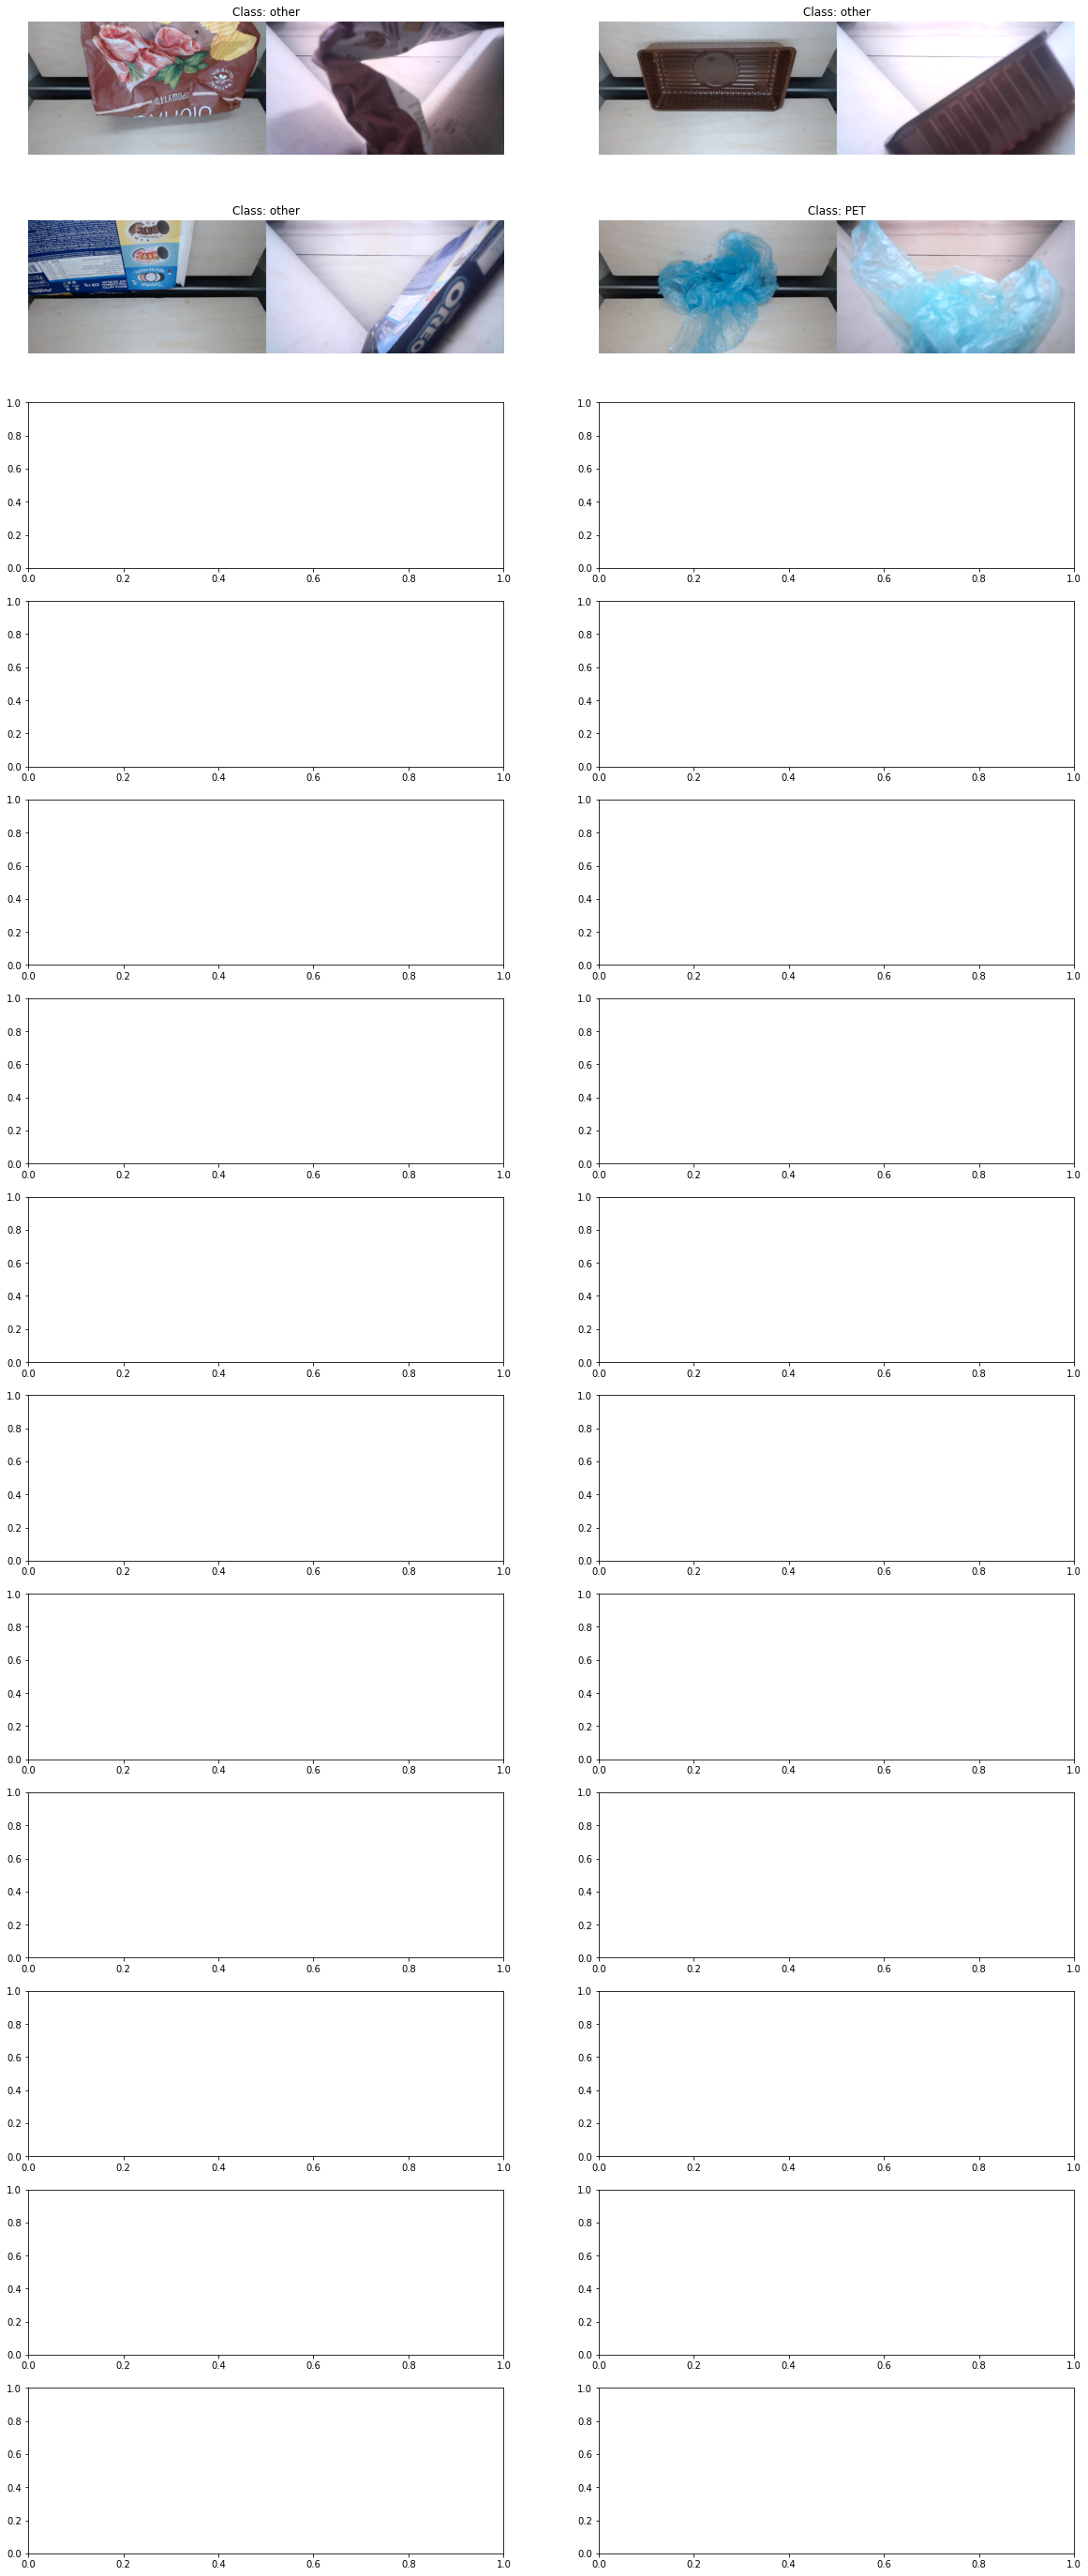

In [29]:
import matplotlib.pyplot as plt
import cv2
# imgs = []
ds = dm.test_dataset_no_transforms
f, axs = plt.subplots(13, 2, figsize=(20,50)) 

id_to_class = {'PET' : 0, 'alum' : 1, 'glass' : 2, 'other' : 3}
id_to_class = dict((v, k) for k, v in id_to_class.items())

for x, id in zip(axs.flatten(), [220, 225, 230, 240]):   
    r = ds[id]
    im_1, im_2 = cv2.cvtColor(r[0], cv2.COLOR_BGR2RGB), cv2.cvtColor(r[1], cv2.COLOR_BGR2RGB)
    img = np.concatenate ((im_1, im_2), axis=1)
    x.imshow(img)
    # x.set_title(f'Class {df["pred"][id]}, metal {r[2]}, weight {r[3]}, probs {outputs[id].numpy()}' )
    # x.set_title(f'Class {id_to_class[df["pred"][id]]}, metal {r[2]}, weight {r[3]}' )

    x.set_title(f'Class: {id_to_class[df["pred"][id]]}' )
    x.axis('off')

plt.savefig('incorrect.png')
